# EDA – ctr_db.json


In [1]:
import json
import pandas as pd
from pathlib import Path

DATA_PATH = Path('../../data/input/ctr_dataset.json')

with open(DATA_PATH) as f:
    data = json.load(f)

df = pd.DataFrame(data)

print(f'Antal rader: {len(df)}')
print(f'Antal kolumner: {len(df.columns)}')
df.head()

Antal rader: 5000
Antal kolumner: 12


,garment_type,color,fit,gender,style,lighting,background,pose,expression,angle,ctr,impressions
0,hoodie,white,loose,unisex,casual_lifestyle,golden_hour,studio_white,walking,serious,side,0.0492,3069
1,zip-up hoodie,dark,regular,unisex,lifestyle_outdoor,dramatic,park,standing,neutral,3/4,0.0452,4300
2,t-shirt,black,tight,female,studio_minimal,studio,nature_outdoor,walking,confident,back,0.0574,1396
3,jacket,colorful,tight,male,lifestyle_outdoor,overcast,studio_grey,sitting,confident,3/4,0.0590,4529
4,jacket,white,regular,unisex,urban_outdoor,golden_hour,urban_street,action,confident,side,0.0527,4549


## CTR Distribution

CTR is our target variable. We look at the distribution in percentage bins (0–1%, 1–2%, ...) to verify the data looks realistic.


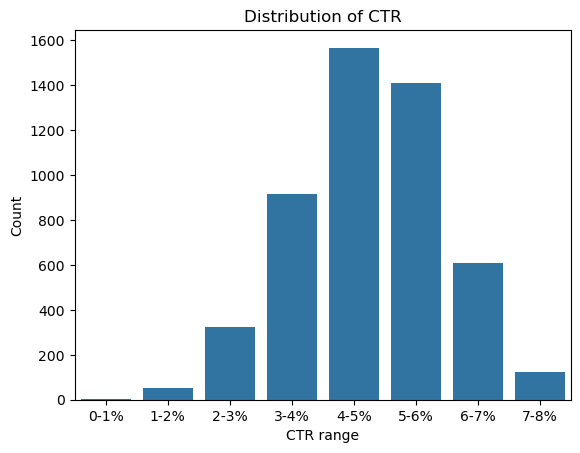

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

bins = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
labels = ['0-1%','1-2%','2-3%','3-4%','4-5%','5-6%','6-7%','7-8%']

df['ctr_bin'] = pd.cut(df['ctr'], bins=bins, labels=labels)

sns.countplot(x='ctr_bin', data=df)
plt.title('Distribution of CTR')
plt.xlabel('CTR range')
plt.ylabel('Count')
plt.show()

## CTR by Garment Type

Average CTR per garment type, and the spread (boxplot) to see how consistent each type is.


garment_type
jacket           5.22
t-shirt          5.05
hoodie           4.99
zip-up hoodie    4.82
jeans            3.73


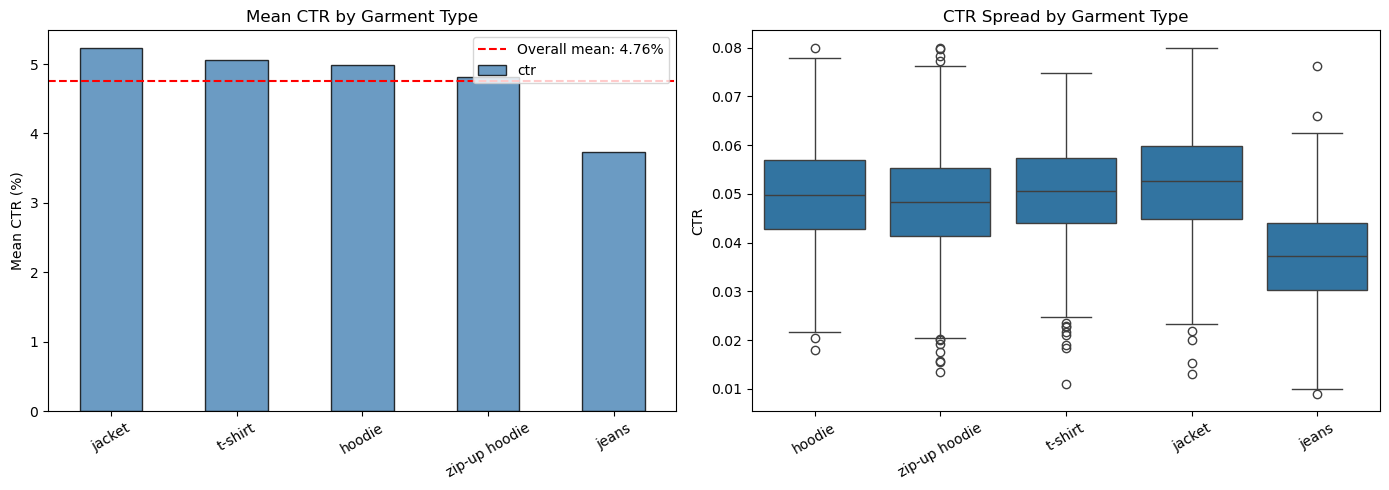

In [ ]:
avg_ctr = df.groupby('garment_type')['ctr'].mean().sort_values(ascending=False) * 100
print(avg_ctr.round(2).to_string())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

avg_ctr.plot(kind='bar', ax=axes[0], edgecolor='black', color='steelblue', alpha=0.8)
axes[0].axhline(df['ctr'].mean() * 100, color='red', linestyle='--', label=f'Overall mean: {df["ctr"].mean()*100:.2f}%')
axes[0].set_title('Mean CTR by Garment Type')
axes[0].set_ylabel('Mean CTR (%)')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=30)
axes[0].legend()

sns.boxplot(x='garment_type', y='ctr', data=df, ax=axes[1])
axes[1].set_title('CTR Spread by Garment Type')
axes[1].set_ylabel('CTR')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

## Class Balance – Garment Type

How many products of each garment type exist in the dataset.


garment_type
jacket           1019
jeans            1007
hoodie            996
t-shirt           996
zip-up hoodie     982


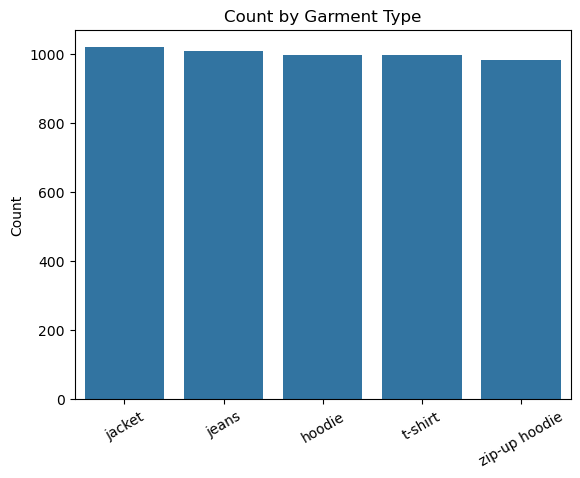

In [4]:
print(df['garment_type'].value_counts().to_string())

sns.countplot(x='garment_type', data=df, order=df['garment_type'].value_counts().index)
plt.title('Count by Garment Type')
plt.xlabel('')
plt.ylabel('Count')
plt.tick_params(axis='x', rotation=30)
plt.show()

## CTR by Gender

Average CTR for male, female, and unisex products.


gender
female    4.87
male      4.77
unisex    4.65


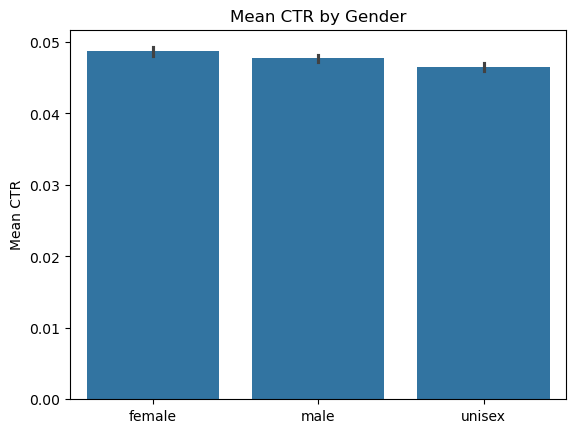

In [5]:
print(df.groupby('gender')['ctr'].mean().sort_values(ascending=False).mul(100).round(2).to_string())

sns.barplot(x='gender', y='ctr', data=df, order=['female', 'male', 'unisex'])
plt.title('Mean CTR by Gender')
plt.ylabel('Mean CTR')
plt.xlabel('')
plt.show()

## Correlation Matrix – All Features vs CTR

Label-encode all categorical variables and compute Pearson correlation with CTR.


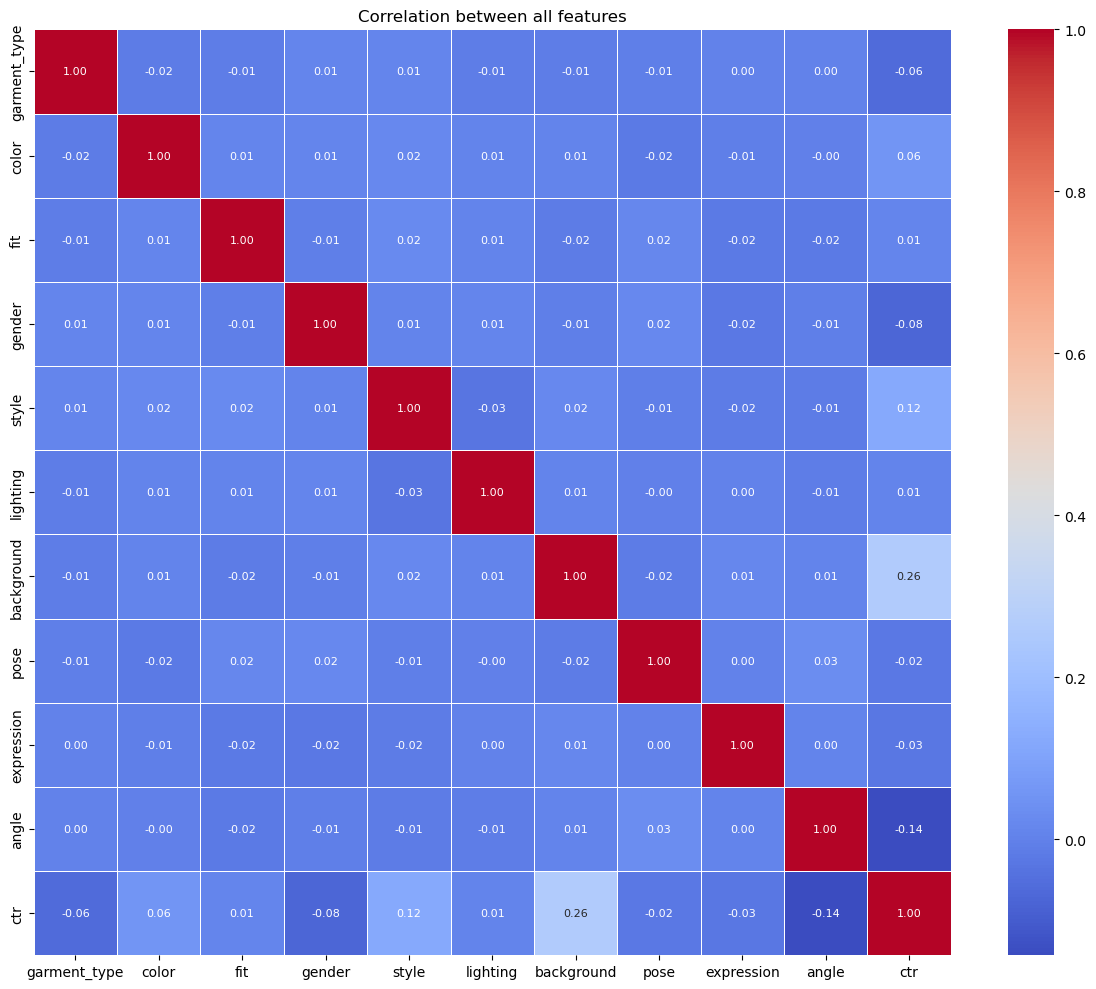

In [6]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ['garment_type', 'color', 'fit', 'gender',
            'style', 'lighting', 'background', 'pose', 'expression', 'angle']

df_enc = df[cat_cols + ['ctr']].copy()
for col in cat_cols:
    df_enc[col] = LabelEncoder().fit_transform(df_enc[col])

corr = df_enc.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm',
            linewidths=0.5, annot_kws={'size': 8})
plt.title('Correlation between all features')
plt.tight_layout()
plt.show()

## Interaction Effect. Style and lighting on CTR

Since no single feature correlates strongly with CTR, we investigate interaction effects.


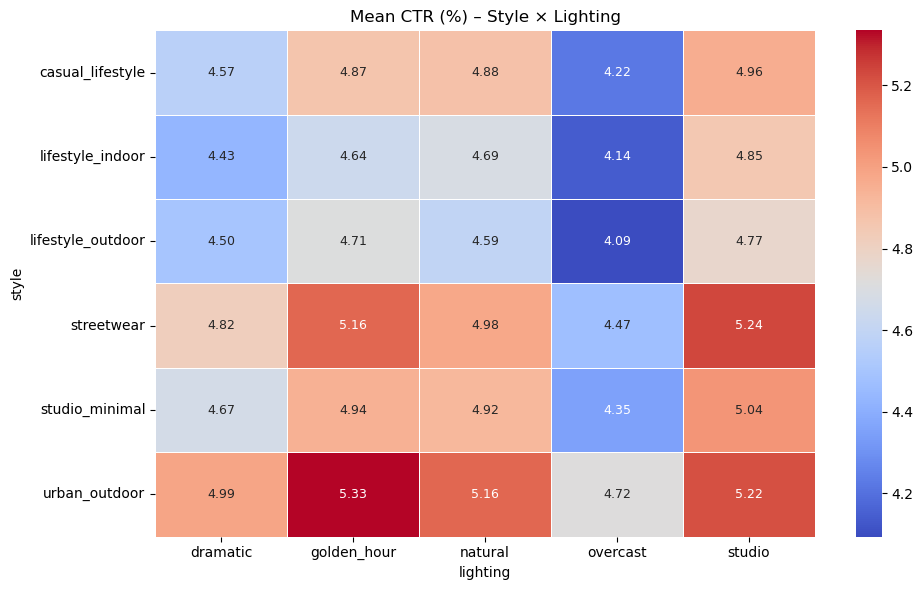

In [7]:
pivot = df.pivot_table(values='ctr', index='style', columns='lighting', aggfunc='mean') * 100

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='coolwarm',
            linewidths=0.5, annot_kws={'size': 9})
plt.title('Mean CTR (%) – Style × Lighting')
plt.tight_layout()
plt.show()

## Interaction Effects. Three more combinations


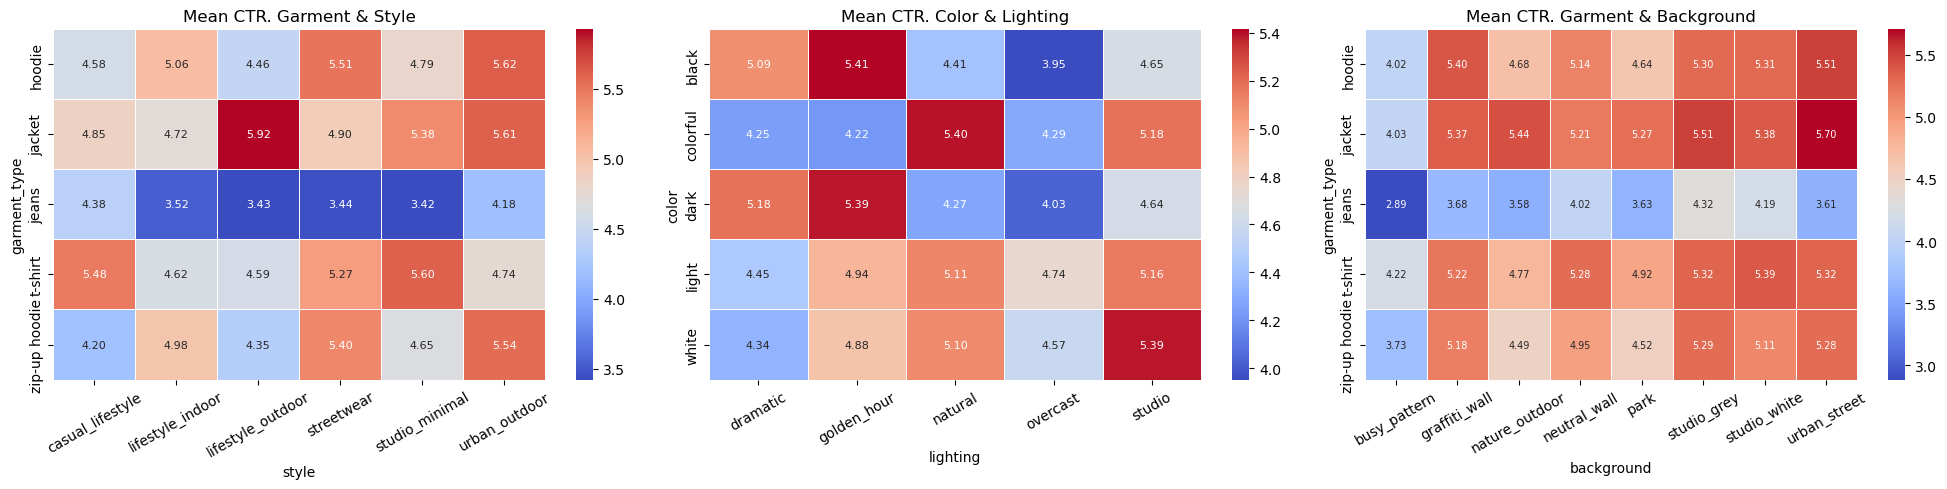

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

p1 = df.pivot_table(values='ctr', index='garment_type', columns='style', aggfunc='mean') * 100
sns.heatmap(p1, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5,
            annot_kws={'size': 8}, ax=axes[0])
axes[0].set_title('Mean CTR. Garment & Style')
axes[0].tick_params(axis='x', rotation=30)

p2 = df.pivot_table(values='ctr', index='color', columns='lighting', aggfunc='mean') * 100
sns.heatmap(p2, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5,
            annot_kws={'size': 8}, ax=axes[1])
axes[1].set_title('Mean CTR. Color & Lighting')
axes[1].tick_params(axis='x', rotation=30)

p3 = df.pivot_table(values='ctr', index='garment_type', columns='background', aggfunc='mean') * 100
sns.heatmap(p3, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5,
            annot_kws={'size': 7}, ax=axes[2])
axes[2].set_title('Mean CTR. Garment & Background')
axes[2].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

## Top 10 Best and Worst Feature Combinations

All pairwise feature combinations ranked by mean CTR.


In [ ]:
from itertools import combinations

cat_cols = ['garment_type', 'color', 'fit', 'gender',
            'style', 'lighting', 'background', 'pose', 'expression', 'angle']

rows = []
for col_a, col_b in combinations(cat_cols, 2):
    grouped = df.groupby([col_a, col_b])['ctr'].agg(['mean', 'count']).reset_index()
    grouped = grouped[grouped['count'] >= 20]  
    grouped['combo'] = grouped[col_a] + ' + ' + grouped[col_b]
    grouped['features'] = f'{col_a} × {col_b}'
    rows.append(grouped[['combo', 'features', 'mean', 'count']])

combo_df = pd.concat(rows).sort_values('mean', ascending=False).reset_index(drop=True)
combo_df['mean_pct'] = (combo_df['mean'] * 100).round(3)

print("TOP 10 BEST COMBINATIONS")
print(combo_df[['combo', 'features', 'mean_pct', 'count']].head(10).to_string(index=False))

print("\nTOP 10 WORST COMBINATIONS")
print(combo_df[['combo', 'features', 'mean_pct', 'count']].tail(10).iloc[::-1].to_string(index=False))

TOP 10 BEST COMBINATIONS
                        combo                  features  mean_pct  count
   jacket + lifestyle_outdoor      garment_type × style     5.924    173
        jacket + urban_street garment_type × background     5.704    122
       hoodie + urban_outdoor      garment_type × style     5.617    153
       jacket + urban_outdoor      garment_type × style     5.610    150
     t-shirt + studio_minimal      garment_type × style     5.603    174
zip-up hoodie + urban_outdoor      garment_type × style     5.545    141
              jacket + action       garment_type × pose     5.518    154
        hoodie + urban_street garment_type × background     5.512    127
         jacket + studio_grey garment_type × background     5.510    124
          hoodie + streetwear      garment_type × style     5.509    174

TOP 10 WORST COMBINATIONS
                    combo                  features  mean_pct  count
     jeans + busy_pattern garment_type × background     2.885    141
       

## CTR Range per Feature

How much can each feature move CTR on its own? High range = the feature carries signal.


garment_type    0.2524
background      0.1868
style           0.1164
lighting        0.0895
pose            0.0789
color           0.0710
expression      0.0616
angle           0.0573
fit             0.0474
gender          0.0388


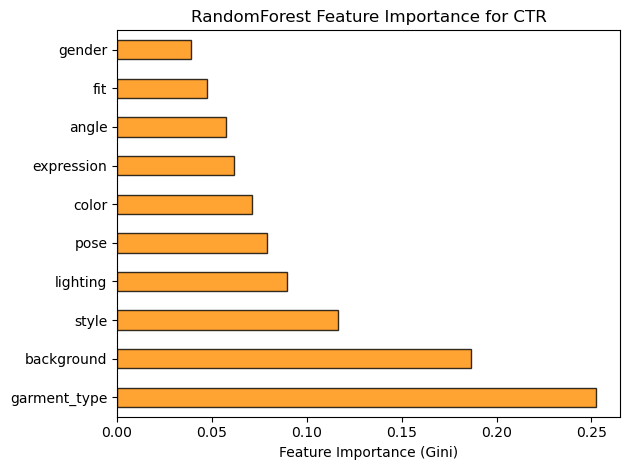

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

cat_cols = ['garment_type', 'color', 'fit', 'gender',
            'style', 'lighting', 'background', 'pose', 'expression', 'angle']

X = pd.get_dummies(df[cat_cols])
y = df['ctr']

rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_imp = {}
for col in cat_cols:
    cols_for_feature = [c for c in X.columns if c.startswith(col + '_')]
    feature_imp[col] = importances[cols_for_feature].sum()

imp_df = pd.Series(feature_imp).sort_values(ascending=False)
print(imp_df.round(4).to_string())

imp_df.plot(kind='barh', edgecolor='black', color='darkorange', alpha=0.8)
plt.xlabel('Feature Importance (Gini)')
plt.title('RandomForest Feature Importance for CTR')
plt.tight_layout()
plt.show()

## Feature Importance – RandomForest

Train a quick RandomForest on all features and extract which features matter most for predicting CTR.


garment_type    1.496
background      1.391
lighting        0.677
pose            0.554
style           0.551
angle           0.535
expression      0.298
gender          0.218
color           0.194
fit             0.082


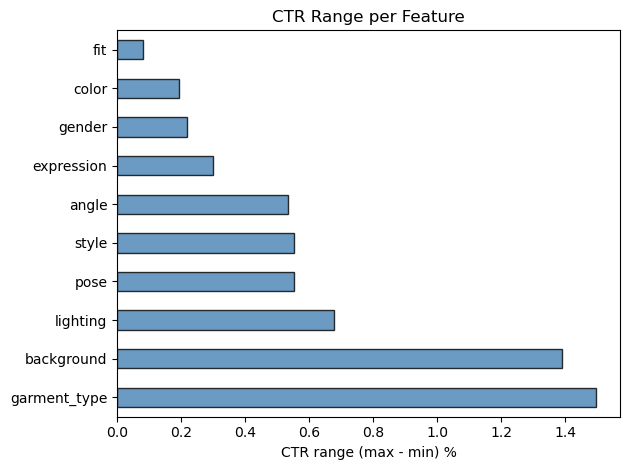

In [11]:
cat_cols = ['garment_type', 'color', 'fit', 'gender',
            'style', 'lighting', 'background', 'pose', 'expression', 'angle']

ranges = {}
for col in cat_cols:
    group = df.groupby(col)['ctr'].mean() * 100
    ranges[col] = round(group.max() - group.min(), 3)

range_df = pd.Series(ranges).sort_values(ascending=False)
print(range_df.to_string())

range_df.plot(kind='barh', edgecolor='black', color='steelblue', alpha=0.8)
plt.xlabel('CTR range (max - min) %')
plt.title('CTR Range per Feature')
plt.tight_layout()
plt.show()